In [1]:
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = (24)
plt.rcParams['xtick.labelsize']="medium"


In [2]:
# determine the center position of the attractor at a given time
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos

def osci_pos_triang_func(stroke,time,frequency,width=0.5):
    osci_pos_triang=stroke/2*signal.sawtooth(2 * np.pi * frequency * time+np.pi/2,width=width)
    return osci_pos_triang

# determine the force for a given point in time using the transformation to position
## sinusoidal movement
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

## triangle movement
def osci_force_func_tri(stroke,time,frequency,pos_vec,force_vec,width=0.5):
    osci_pos_triang = osci_pos_triang_func(stroke,time,frequency,width=width)
    return np.interp(osci_pos_triang,pos_vec,force_vec, left=None, right=None, period=None)

# normalization for used ASD
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

def generate_white_noise(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    fft = np.real(np.fft.rfft(noise_randomized))
    freq3 = np.fft.rfftfreq(length, d=1./fs)
    ps = fft*fft.conj().real*fft_norm(len(noise_randomized),fs)**2
    return ps,freq3

# make some white noise and finally learn how and why things are normalized that way
def generate_white_noise2(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    psd_noise,freq_n = psd(noise_randomized,NFFT=length,Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    norm=0.5*fs
    return psd_noise*norm,freq_n

# define a function to obtain the response given a number of harmonics
def function_response(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,plot):
    force_vec = force_vec * alpha
    time = np.arange(0,int_time,1/sampling_frequency)
    psd_dat2,freq2 = psd(osci_force_func(stroke,time,frequency,pos_vec,force_vec), 
                         NFFT=len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)), 
                         Fs=sampling_frequency, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,340)
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [3]:
#input signal model

res_dict_side_by_side = pkl.load( open('/home/analysis_user/Results/Sensitivity/rbead_2.4e-06_sep_7.5e-06_height_0.p', 'rb'))
## initate a few values in order to do diagnostics
int_time = 1 # keep that 1 for now
alpha = 1 # alpha to scale the yukawa force
sampling_frequency = 5000 # should be 5000 
time = np.arange(0,int_time,1/sampling_frequency) # make a time array
separation = 7.5e-6 # separation is set by the file you load TODO automatize
lambda_par= 1e-5 # pick a lambda parameter
stroke1=400e-6
force_x = res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary

frequency = 13
psd_dat,freq = psd(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk), 
                   NFFT=len(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)), Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)



In [4]:
def get_harmonics(frequency,input_data,no_harmonics=np.arange(1,192,1)):
    harmonics=[]
    for i in no_harmonics:
        harmonics.append(input_data[frequency*i])
    return harmonics    

In [5]:
harmonics = get_harmonics(13,psd_dat,no_harmonics=(np.arange(1,192,1)))

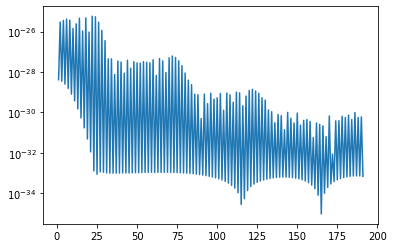

In [9]:
x=np.arange(1,192,1)
plt.plot(x,np.sqrt(harmonics))
plt.yscale("log")
#plt.xscale("log")

In [7]:
x_interp = np.arange(1,192,0.00001)
signal_model = np.interp(x_interp,x,harmonics, left=None, right=None, period=None)

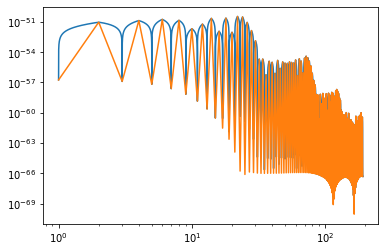

In [8]:
plt.plot(x_interp,signal_model)
plt.plot(x,harmonics)
plt.yscale("log")
plt.xscale("log")

In [7]:
# data from AkioK

data_array = np.loadtxt("../../Results/AkioK/2019_08_12_Bead1/ShakeNSDPhase138.txt")

In [17]:
data_transposed = np.transpose(data_array)

In [59]:
len(data_transposed[1])

192

(0, 250)

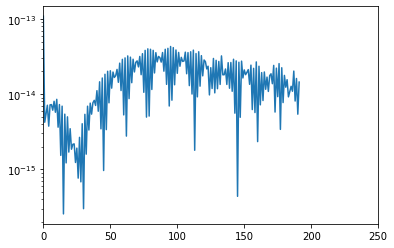

In [28]:
plt.plot(data_transposed[1])
plt.yscale("log")
plt.xlim(0,250)

ValueError: x and y must have same first dimension, but have shapes (49,) and (191,)

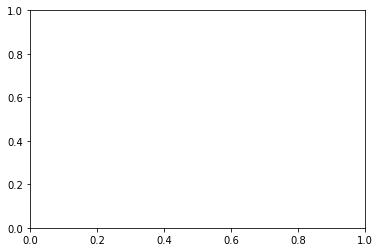

In [72]:
x=np.arange(1,50,1)
plt.plot(x,np.sqrt(harmonics))
plt.yscale("log")
#plt.xscale("log")

In [66]:
# EXAMPLE 2: Generic 

def gaussian(x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]

def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_gaussian(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def ndf_gaussian():
    return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[1]


In [37]:
# load the data
Day = "13"
Month = "08"
Year = "2019"
BeadNumber = 1
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/Shaking/"
files = load_dir(folder, file_prefix = 'Shaking1_', max_file=500)


pos_x = files[0].xyz2[0]
pos_x1 = files[1].xyz2[0]


10  files in folder
10  files loaded


In [69]:
psd_dat1,freq = psd(pos_x1, 
                   NFFT=len(pos_x1), Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)

harmonics_dat1 = get_harmonics(130,np.sqrt(psd_dat1),no_harmonics=(np.arange(1,192,1)))

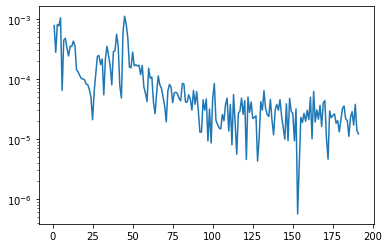

In [71]:
#plt.plot(x,harmonics_dat)
plt.plot(x,harmonics_dat1)
plt.yscale("log")
#plt.xscale("log")

In [90]:
## include the transfer function

def damped_osc_amp(f, A, f0, g):
    '''Fitting function for AMPLITUDE of a damped harmonic oscillator
           INPUTS: f [Hz], frequency 
                   A, amplitude
                   f0 [Hz], resonant frequency
                   g [Hz], damping factor
           OUTPUTS: Lorentzian amplitude'''
    w = 2. * np.pi * f
    w0 = 2. * np.pi * f0
    denom = np.sqrt((w0**2 - w**2)**2 + w**2 * g**2)
    return A / denom

def damped_osc_phase(f, A, f0, g, phase0 = 0.):
    '''Fitting function for PHASE of a damped harmonic oscillator.
       Includes an arbitrary DC phase to fit over out of phase responses
           INPUTS: f [Hz], frequency 
                   A, amplitude
                   f0 [Hz], resonant frequency
                   g [Hz], damping factor
           OUTPUTS: Lorentzian amplitude'''
    w = 2. * np.pi * f
    w0 = 2. * np.pi * f0
    return A * np.arctan2(-w * g, w0**2 - w**2) + phase0

In [110]:
# load the data
Day = "13"
Month = "08"
Year = "2019"
BeadNumber = 1
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/TransFunc/"
files = load_dir(folder, file_prefix = 'TransFuncX_', max_file=500)
pos_x = files[0].xyz2[0]

fbase=7

xpsd, freqs = mlab.psd(pos_x, Fs = 5000, NFFT = len(pos_x),window=mlab.window_none)

Noise0X=np.sqrt(xpsd[fbase*10])
XnoiseX=np.sqrt(xpsd)


No cantilever data
Error loading spinning data
1  files in folder
1  files loaded


In [111]:
q=9
V=0.65
F=(q*1.602e-19)*(V*2/8.6e-3*0.65)
Nharm=100
FnoiseXX=XnoiseX/Noise0X*F
TFXX=np.zeros(Nharm)
FreqTF=np.zeros(Nharm)
for i in range(Nharm):
    FreqTF[i]=fbase*(i+1)
    TFXX[i]=FnoiseXX[fbase*10*(i+1)]


(10, 700)

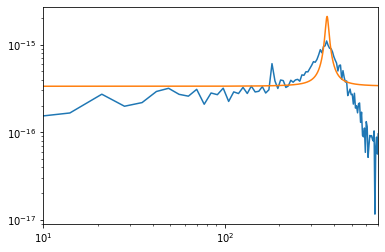

In [128]:
plt.plot(FreqTF,TFXX)
plt.yscale("log")
plt.xscale("log")
plt.plot(freqs,damped_osc_amp(freqs, 4e2*A, w0x, gx))
plt.xlim(10,700)

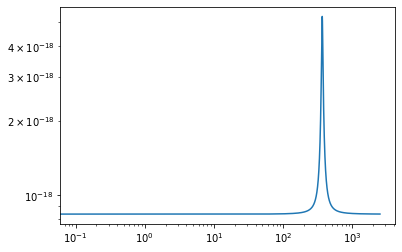

In [119]:
#plt.plot(FreqTF,TFXX)
f0=151
w0x=366.087
gx=94.8771
F0x=1/np.sqrt((f0*f0-w0x*w0x)*(f0*f0-w0x*w0x)+gx*gx*f0*f0)
A = 3.71e-12*F0x*np.sqrt((freqs*freqs-w0x*w0x)*(freqs*freqs-w0x*w0x)+gx*gx*freqs*freqs)
plt.plot(freqs,damped_osc_amp(freqs, A, w0x, gx))
plt.yscale("log")
plt.xscale("log")

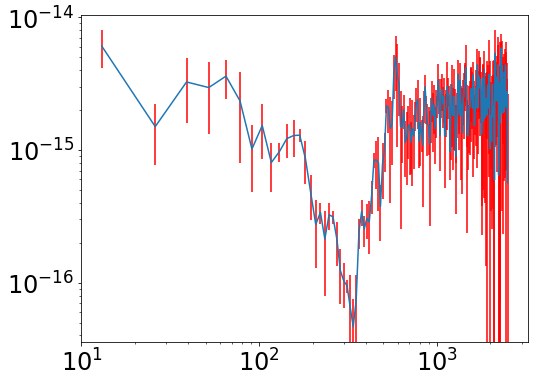

In [95]:
plt.errorbar(data_2_transposed[0],data_2_transposed[1],data_2_transposed[2],ecolor="Red")
plt.yscale("log")
plt.xscale("log")

In [92]:
data_x = data_2_transposed[0]  # give x data
data_y = data_2_transposed[1] # give y data 
data_y_error = data_2_transposed[2] # give y uncertainty

In [ ]:
area=0
mean=0
sigma=0
constant=0

m=Minuit(chisquare_gaussian, 
         area = 410e7, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #fix_area = "True", # you can also fix it
         mean = 3650,
         #fix_mean = "True",
         limit_mean = (3500,4500),
         sigma = 150,
         constant = 0,
         #fix_constant=0,
         errordef = 1,
         print_level=1)
print('Now proceed with the fit.')
m.migrad(ncall=500000)
print()
#m.minos(), if you need fancy mapping
chisquare=m.fval
print(chisquare)

In [ ]:
plt.plot(time_sub,subset)
plt.plot(time_sub,gaussian(time_sub,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]))
plt.xlim(3500,4000)